In [1]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [2]:
time_start = time.time()

In [3]:
b = BLEPipeline()

In [4]:
# b.extract_packet_features(create_master=True)

In [5]:
df = b.make_dataframe()

August2    210644
Home1       54902
Home2       54516
Push        30661
Kevo        19430
August1     15047
Weather      8101
Room2        7698
Room1        7239
Door1        6696
Door2        3587
Name: Name, dtype: int64


## Data Exploration

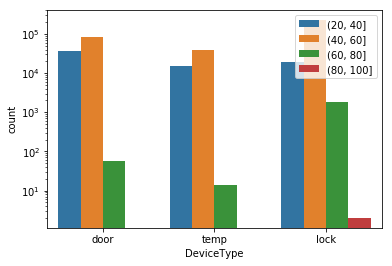

In [6]:
g = sns.countplot(x=df['DeviceType'], hue=pd.cut(df['PacketLength'], bins=[20, 40, 60, 80, 100]));
g.set_yscale('log')
plt.legend(loc='upper_right');

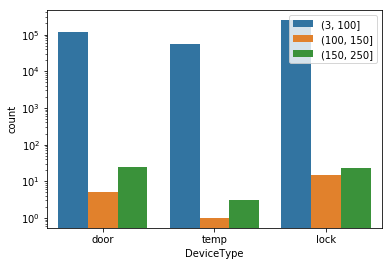

In [7]:
g = sns.countplot(x=df['DeviceType'], hue=pd.cut(df['BLE_LL_Length'], bins=[3,100,150,250]));
g.set_yscale('log')
plt.legend(loc='upper_right');

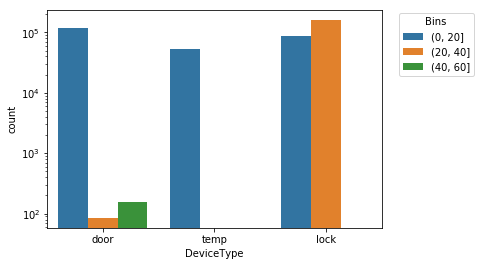

In [8]:
g = sns.countplot(x=df['DeviceType'], hue=pd.cut(df['Assoc_Packets'], bins=[0,20,40,60]));
g.set_yscale('log')
plt.legend(title='Bins', bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0.);

0     165804
39    133898
12    118819
Name: RFChannel, dtype: int64


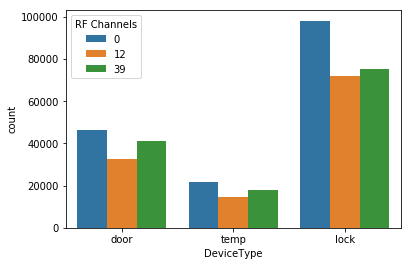

In [9]:
g = sns.countplot(x=df["DeviceType"], hue=df["RFChannel"]);
print df['RFChannel'].value_counts()
plt.legend(title='RF Channels', loc='upper_left');

ADV_IND            323515
SCAN_RSP            79045
SCAN_REQ            15530
ADV_NONCONN_IND       373
ADV_DIRECT_IND         45
ADV_SCAN_IND            9
CONNECT_REQ             4
Name: PDUType, dtype: int64


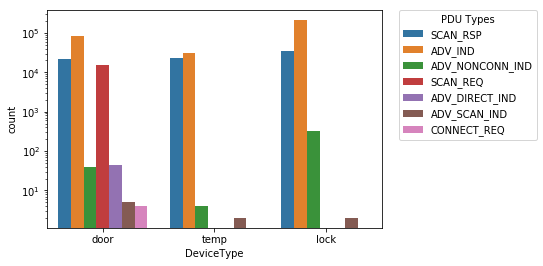

In [10]:
g = sns.countplot(x=df["DeviceType"], hue=df["PDUType"]);
print df['PDUType'].value_counts()
g.set_yscale('log')
plt.legend(title='PDU Types', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [11]:
features_list = [
    # Packet info
    "PacketLength", "BLE_LL_Length",
    
    # Associate Packets
    "Assoc_Packets",
    
    # Channel number
    "Channel_0", "Channel_12", "Channel_39",
    
    # PDU Type
    "SCAN_RSP", "ADV_IND", "SCAN_REQ", 
    "CONNECT_REQ", "ADV_NONCONN_IND", "ADV_DIRECT_IND"]

y_list = ["door", "lock", "temp"]

## Resample

### Downsampling

In [12]:
# Remove router device type and plug device type (not using plug because not enough devices)
df = df[(df["DeviceType"]!="router") & (df["DeviceType"]!="plug")]

df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'DeviceName', 'Set', 
                  'AccessAddr', 'AdvertAddr','PDUTypeNum'}
onehotEncoded_vars = {'ADV_DIRECT_IND', 'ADV_IND', 
                      'ADV_NONCONN_IND', 'ADV_SCAN_IND', 
                      'CONNECT_REQ', 'SCAN_REQ', 'SCAN_RSP'}
response_vars = {"DeviceType","door","lock","temp"}
ble_devicetypes = ["door","lock","temp"]

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | onehotEncoded_vars
X = df_train.drop(col_drop, axis=1)

### Create trial dataframes

In [13]:
df_trials = []
num_trials = 10
while len(df_trials) != num_trials:
    df_downsampled = b.downsample(X, y, df[df["Set"]=="test"])

    # Ensure that the trial sample contains all features in feature list
    if set(features_list).issubset(set(df_downsampled.columns)):
        df_trials.append(df_downsampled)

## Run trials

In [14]:
trial_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i+1
    result = b.one_vs_all_classify(trial, [x for x in features_list if x in trial.columns], y_list)
    trial_results.append(result)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


## Reports

### Plot ROC plots, report AUC

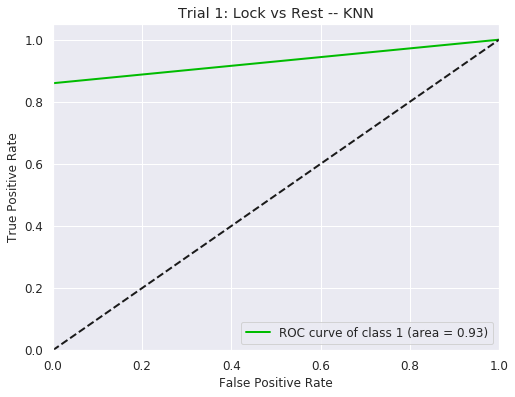

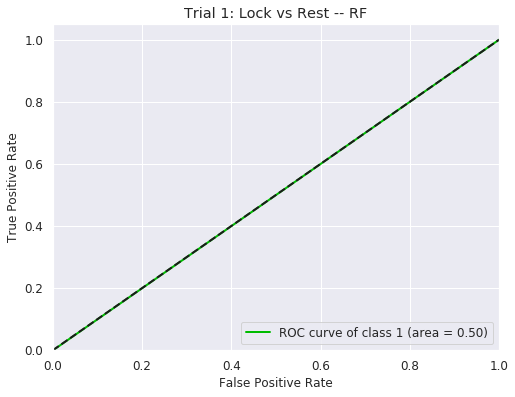

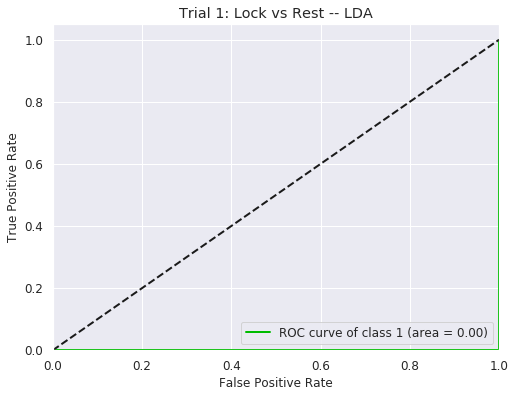

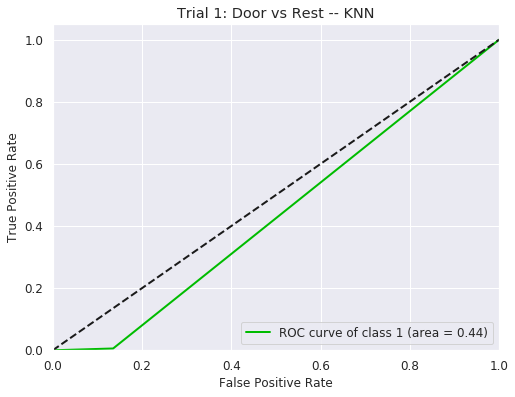

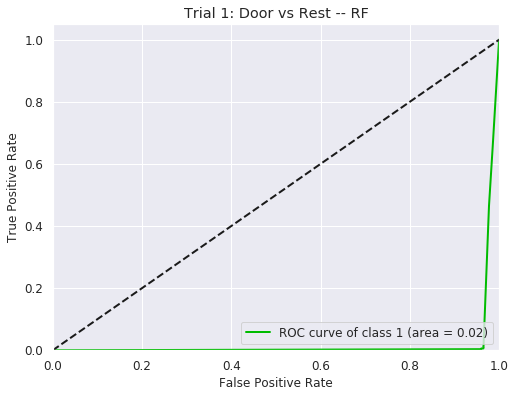

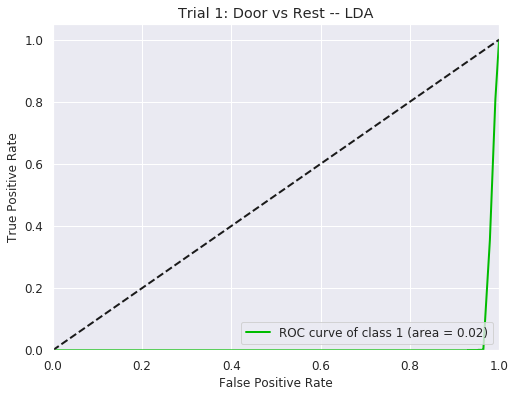

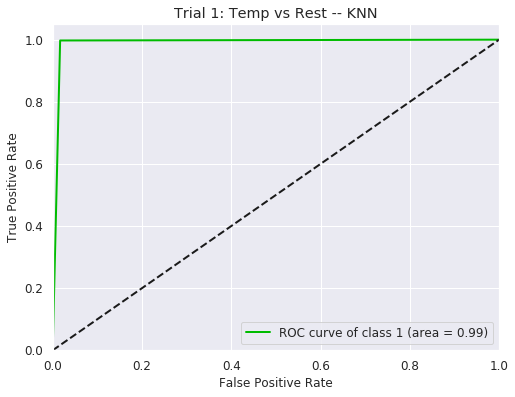

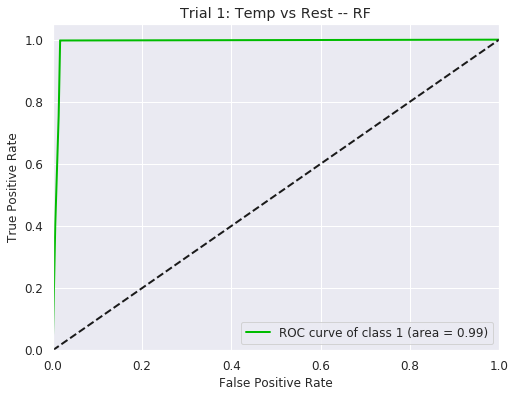

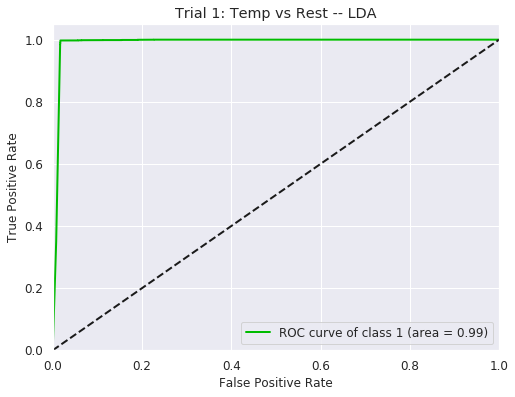

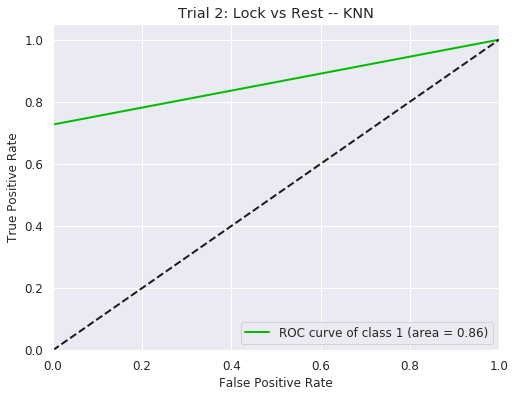

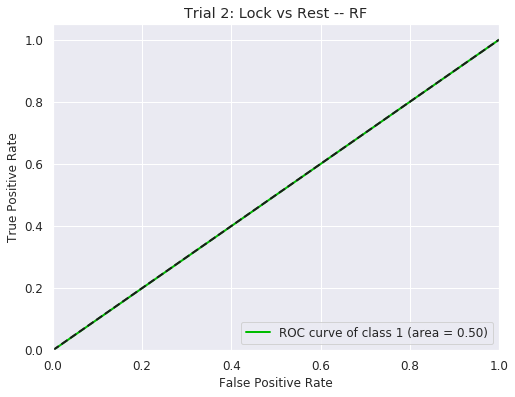

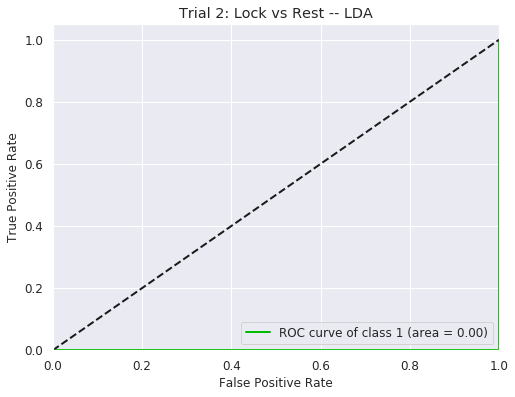

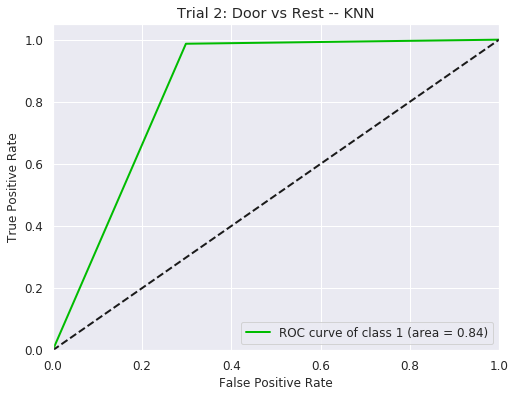

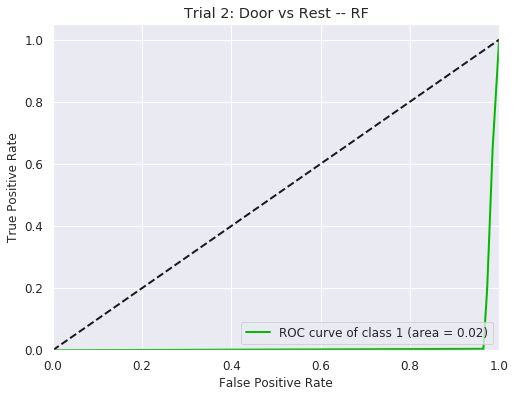

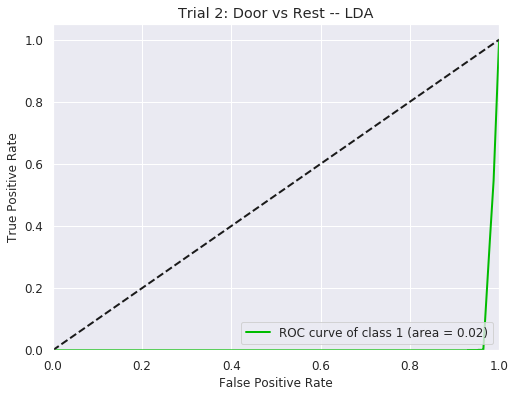

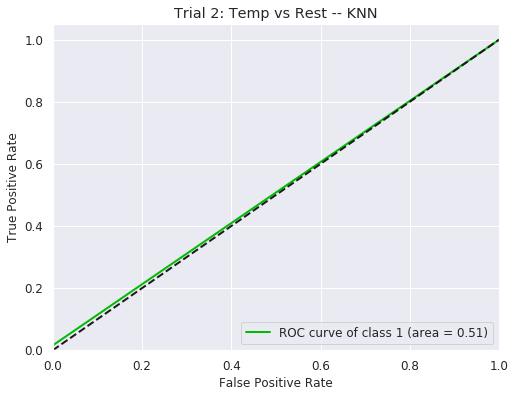

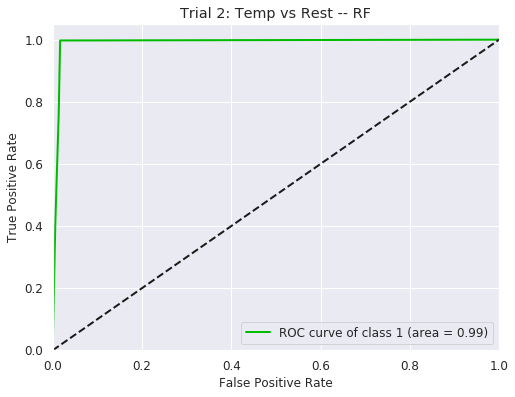

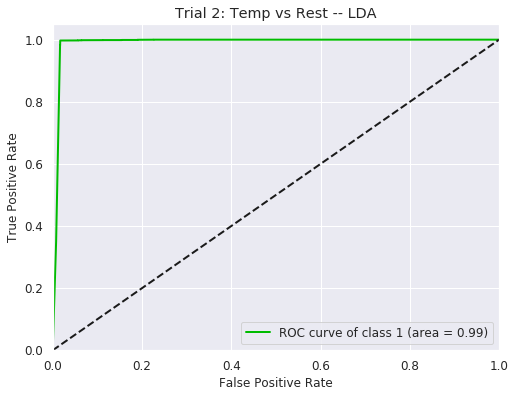

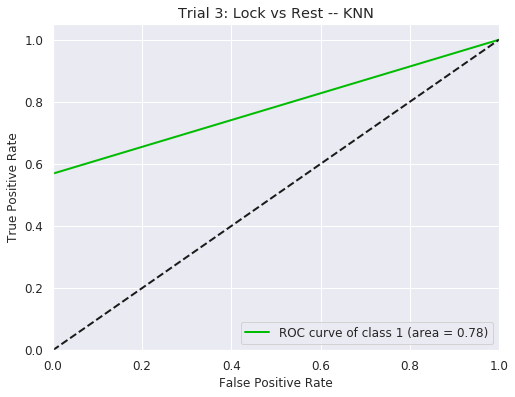

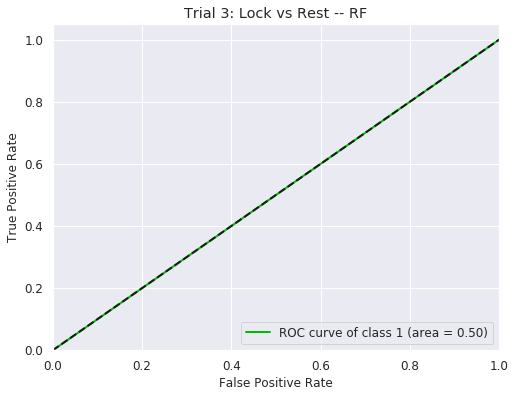

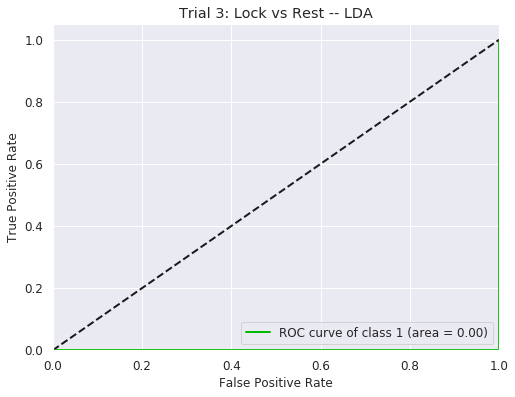

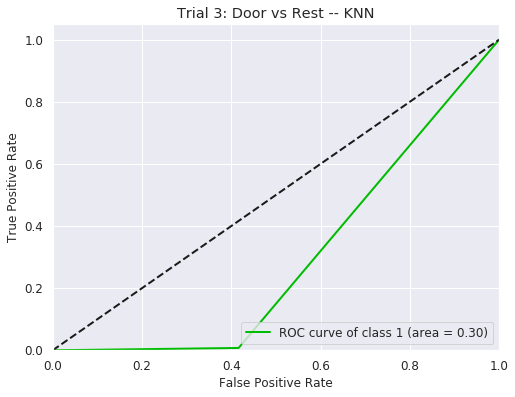

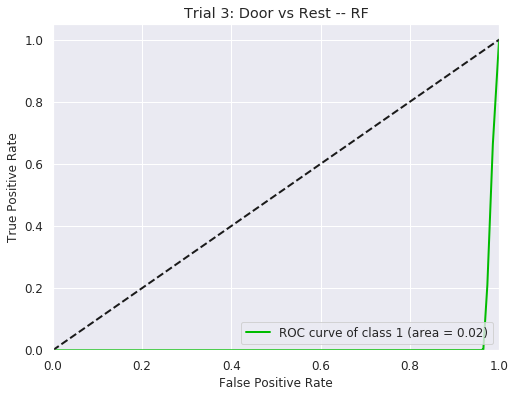

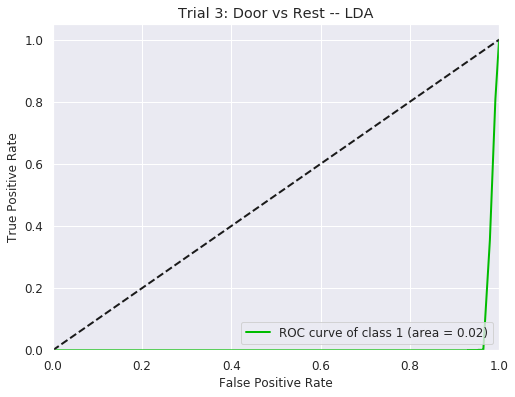

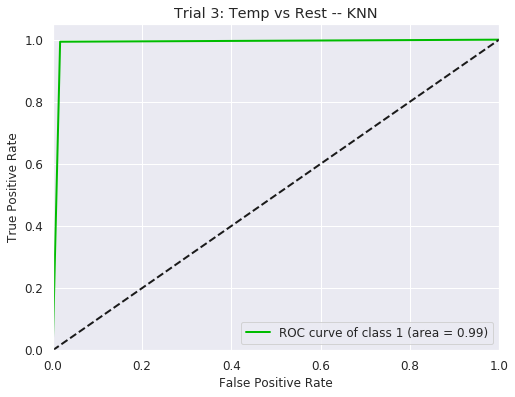

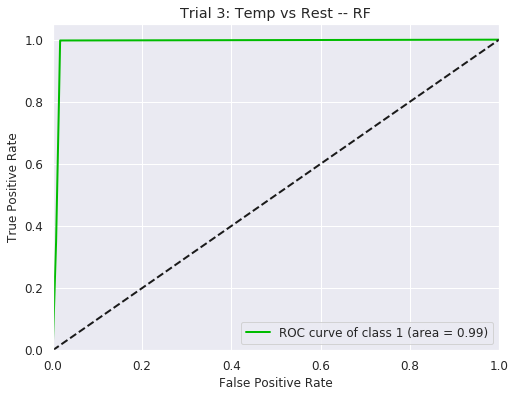

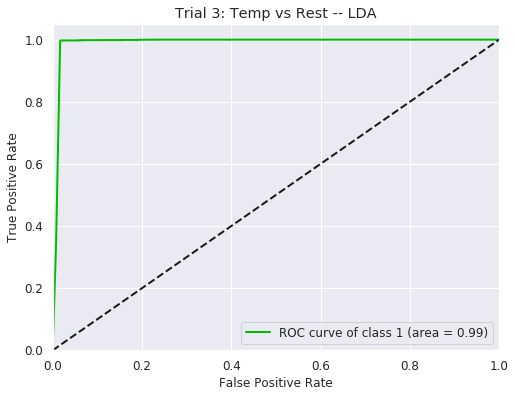

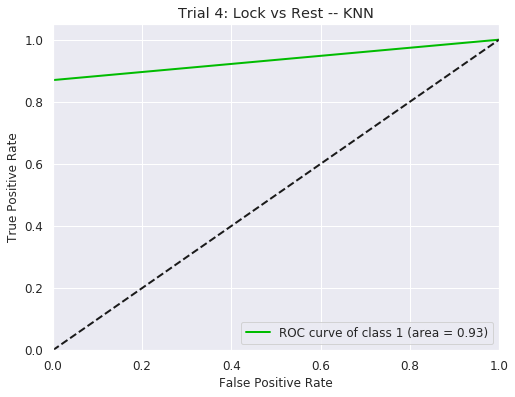

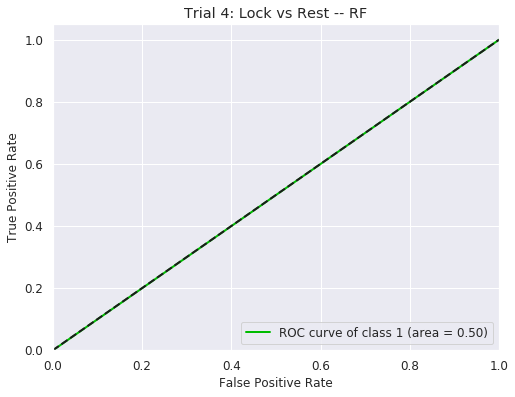

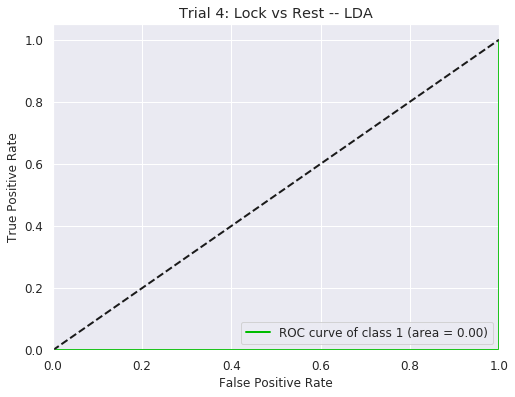

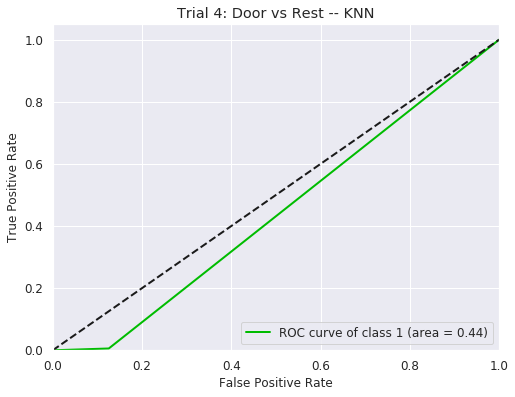

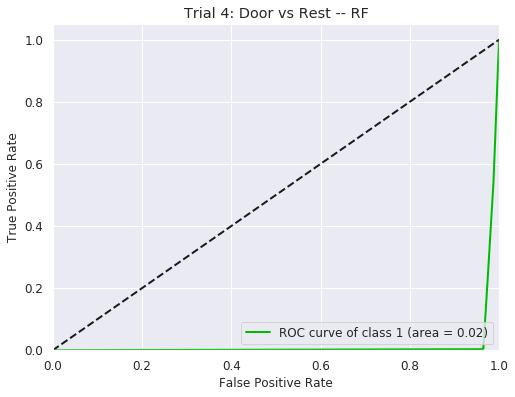

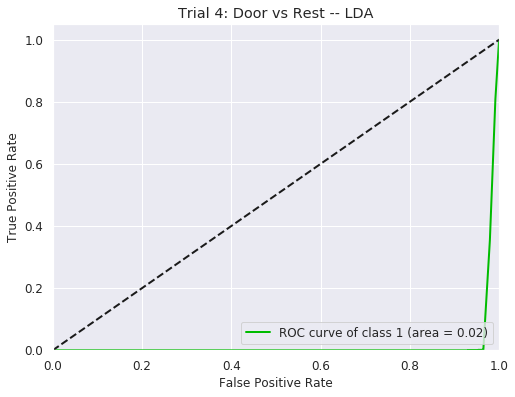

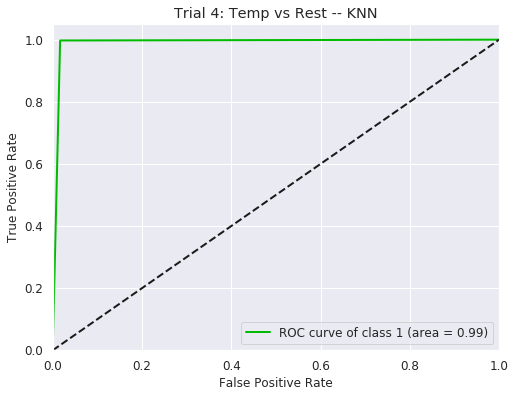

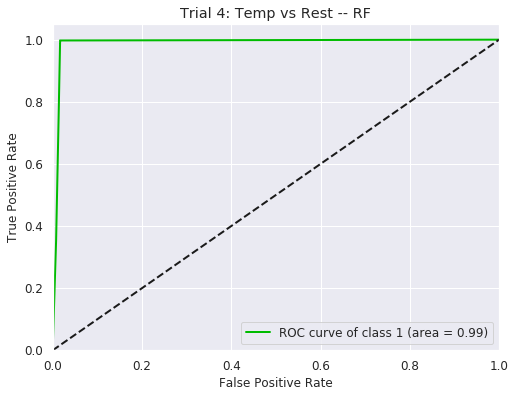

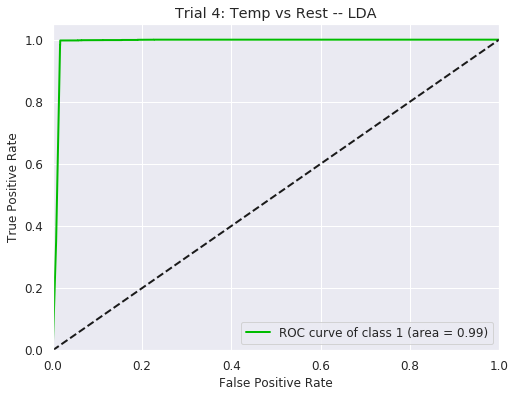

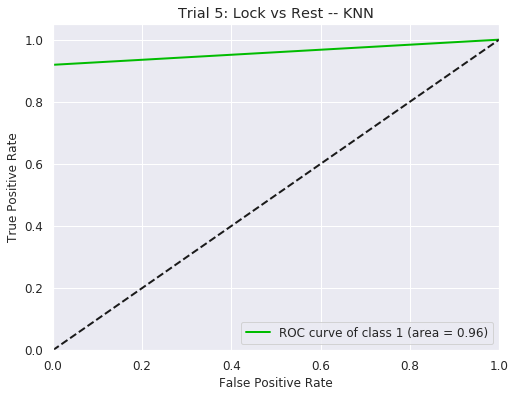

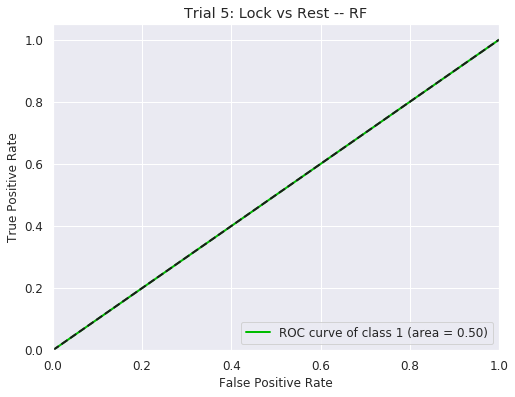

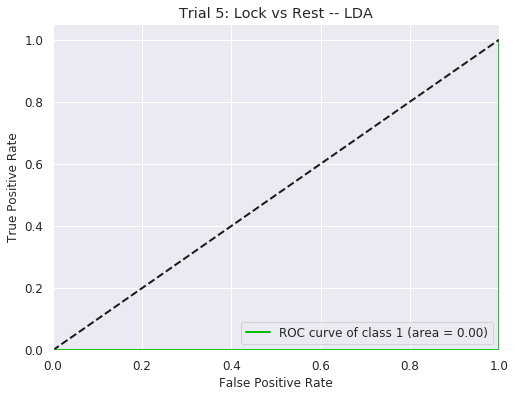

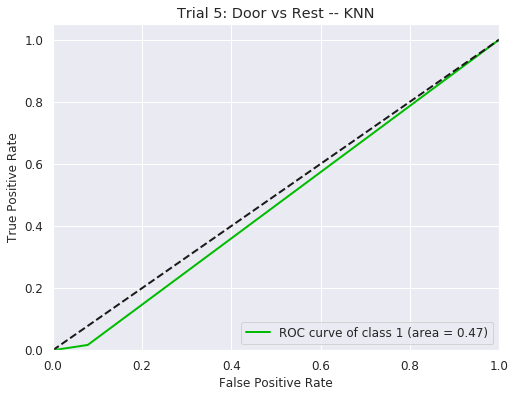

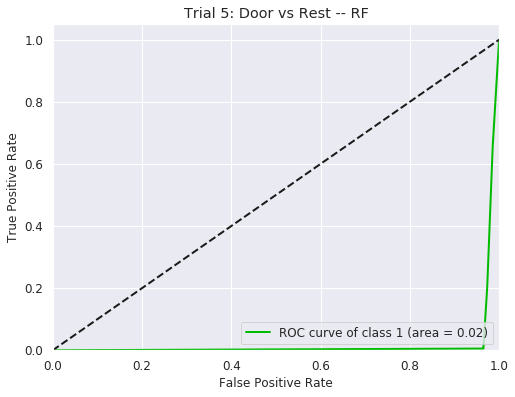

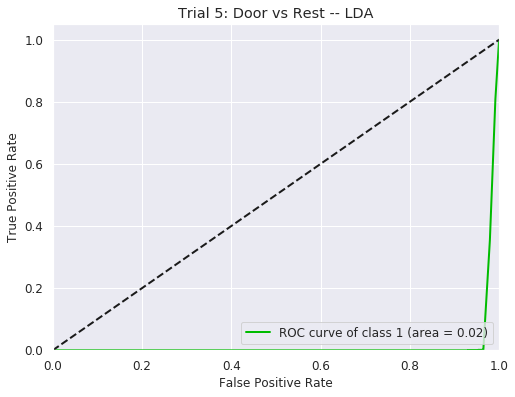

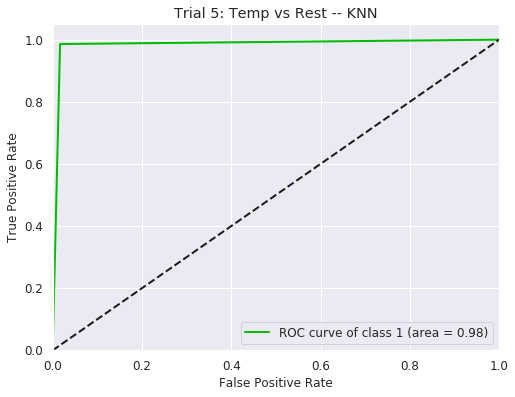

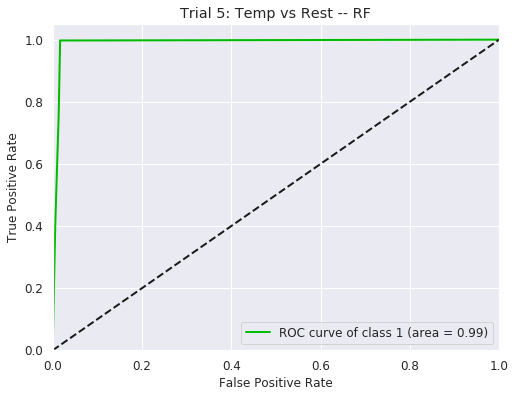

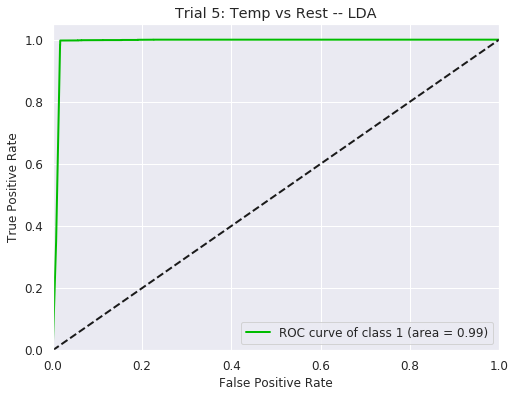

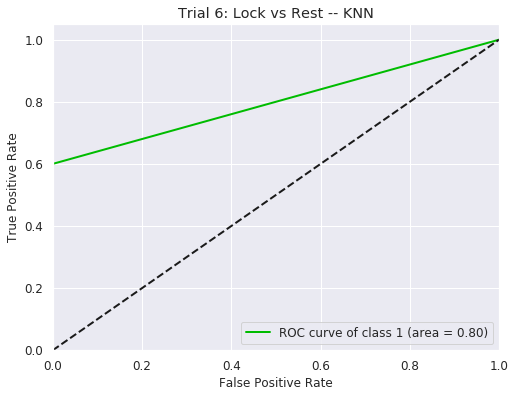

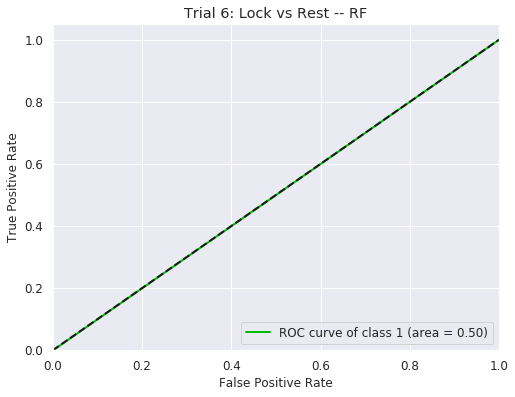

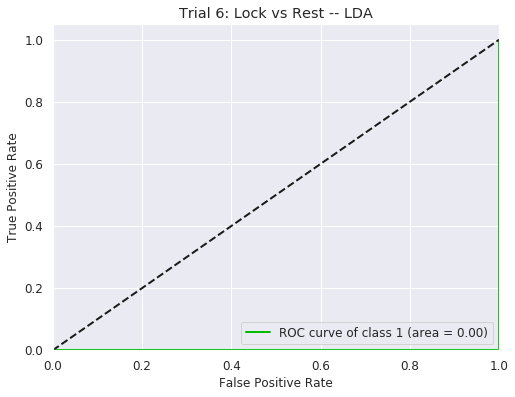

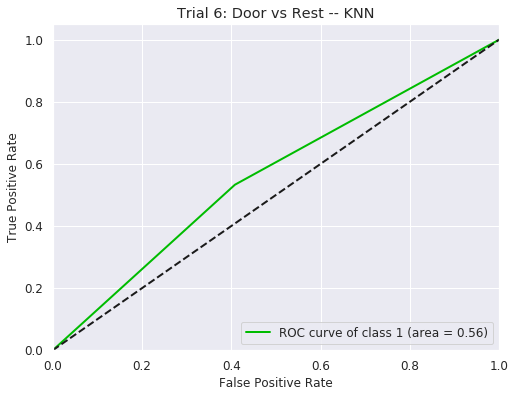

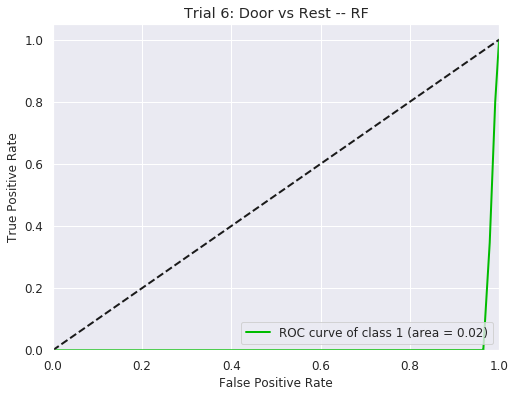

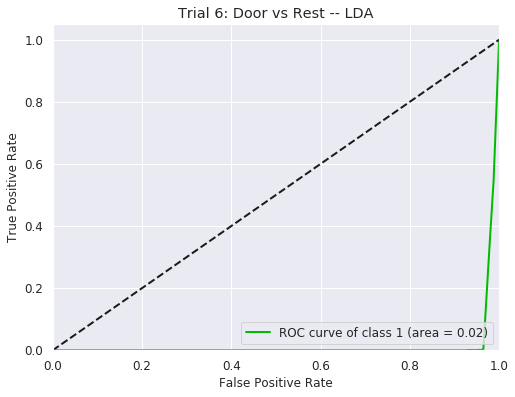

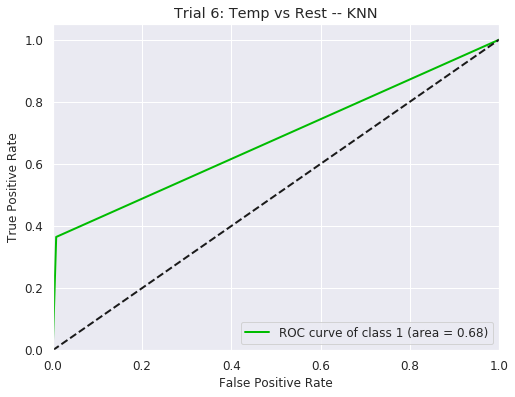

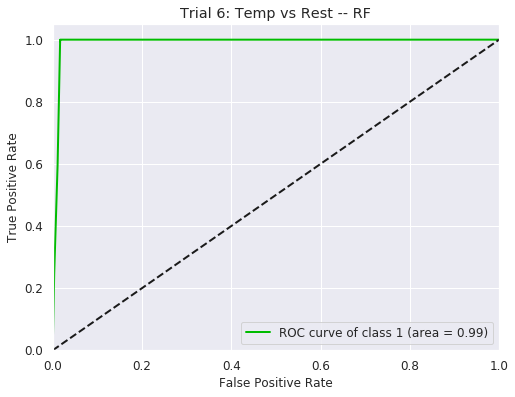

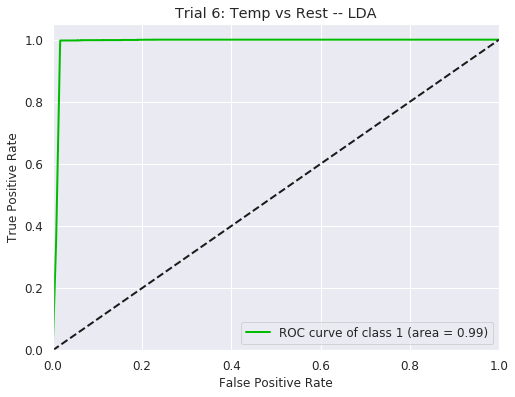

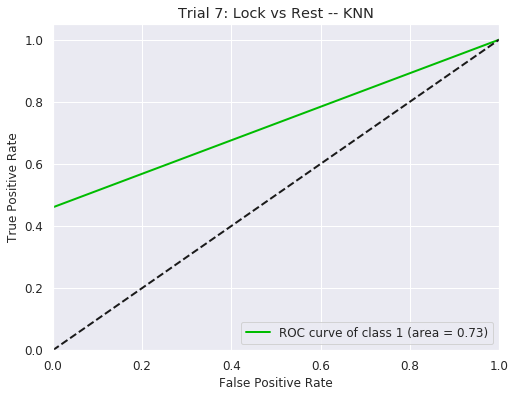

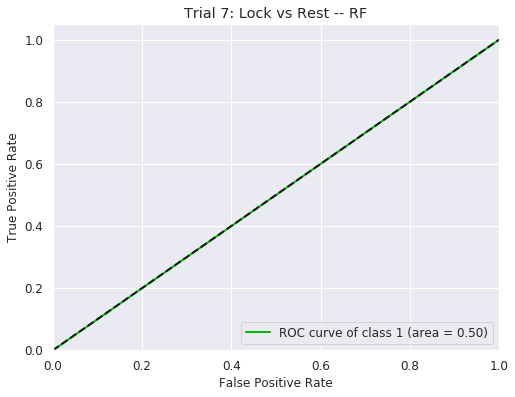

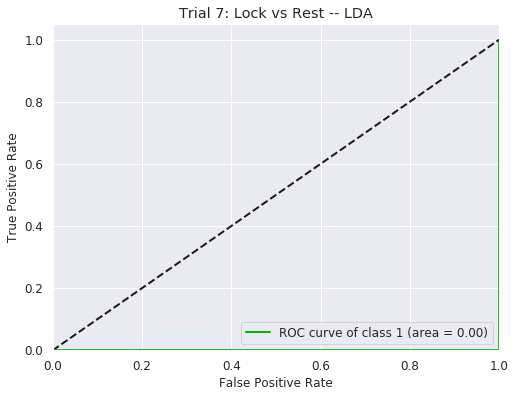

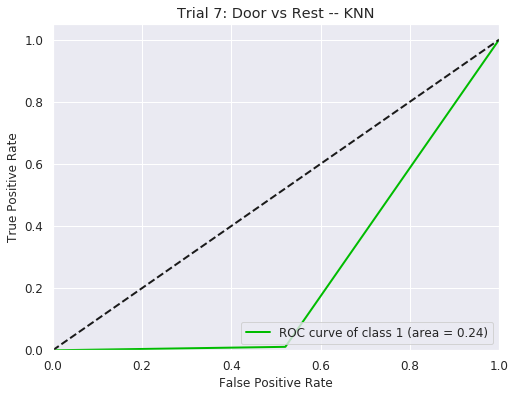

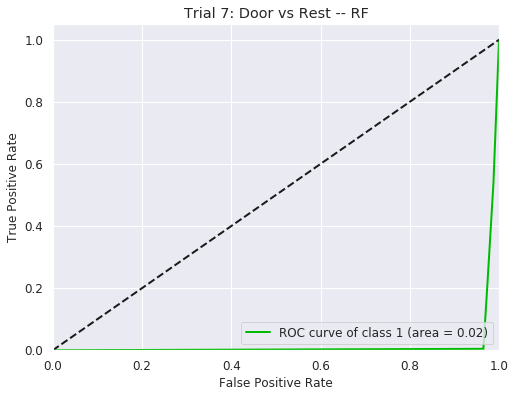

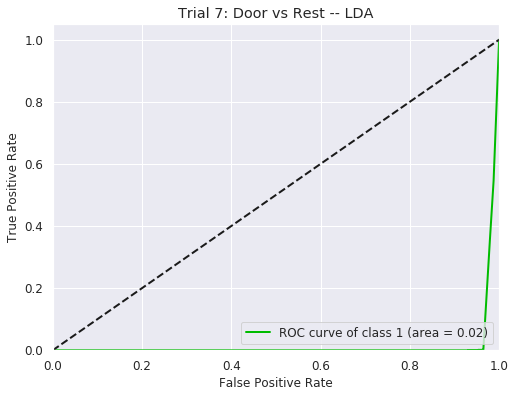

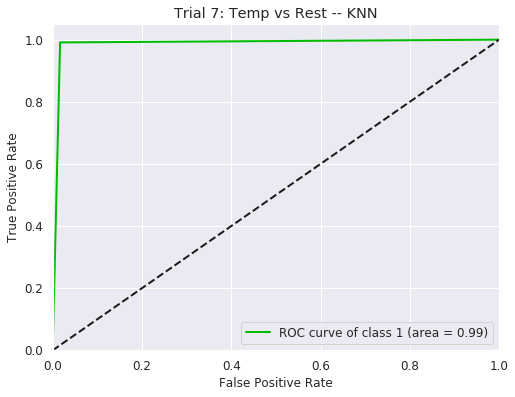

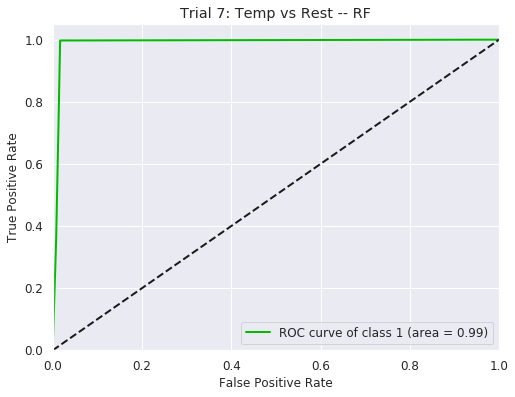

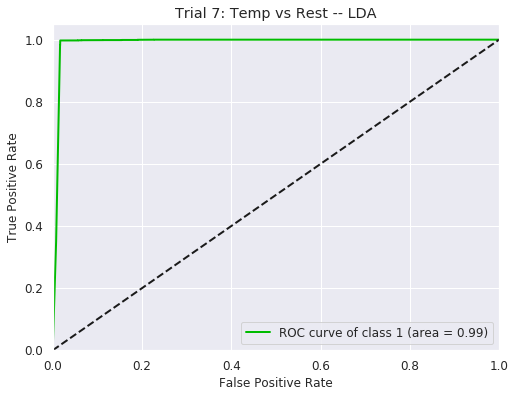

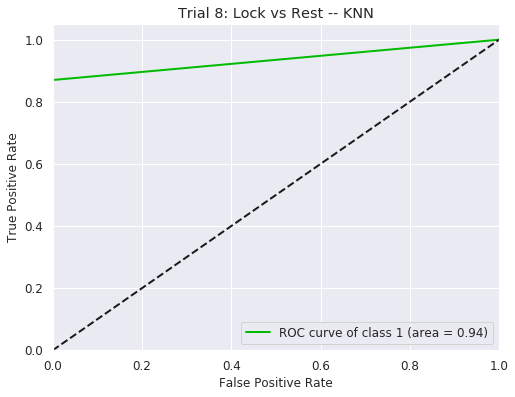

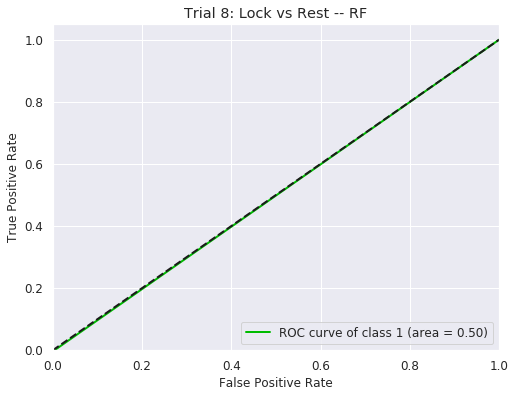

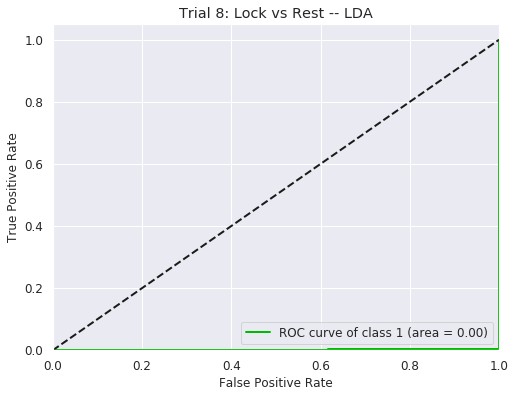

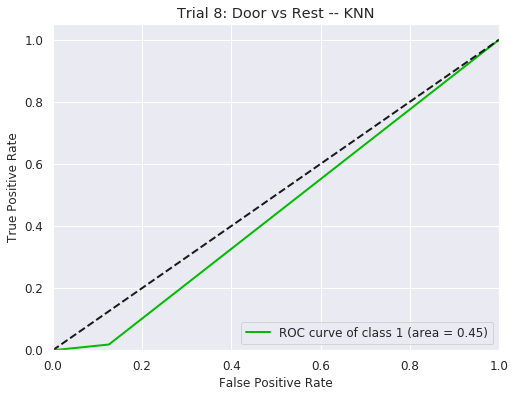

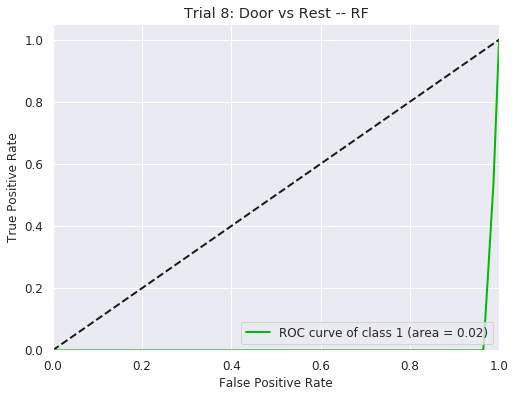

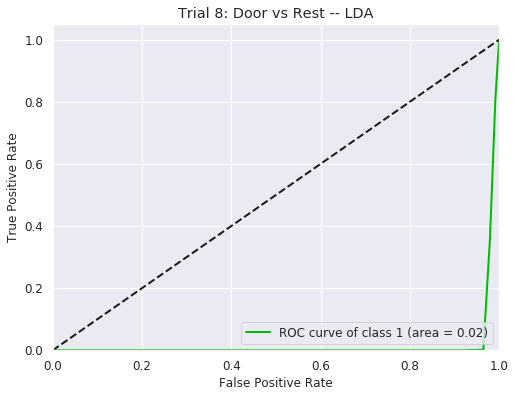

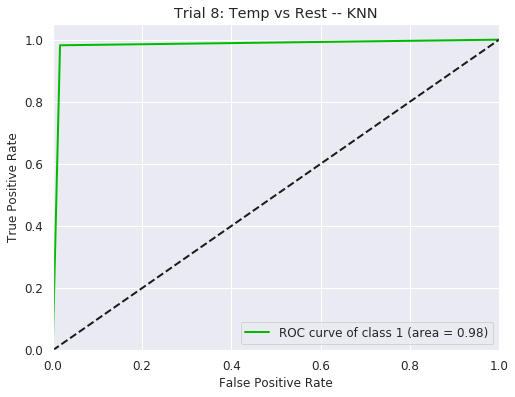

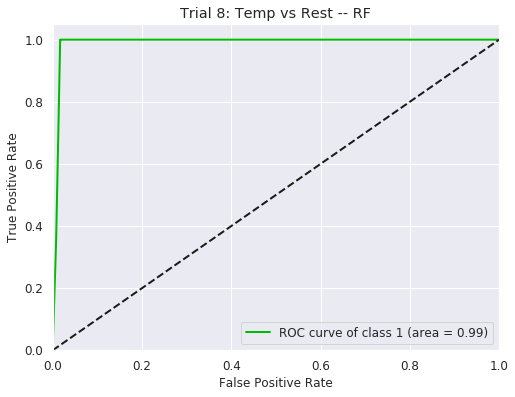

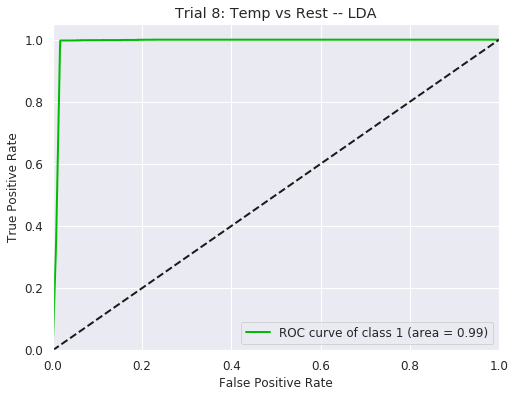

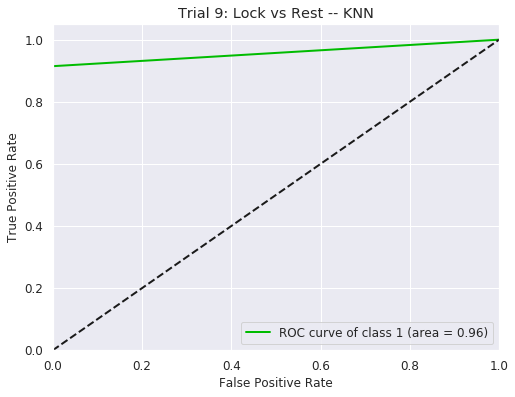

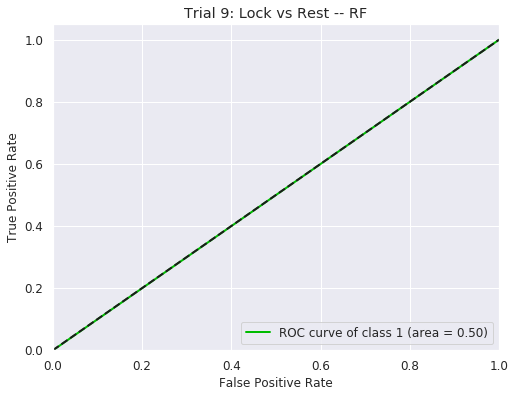

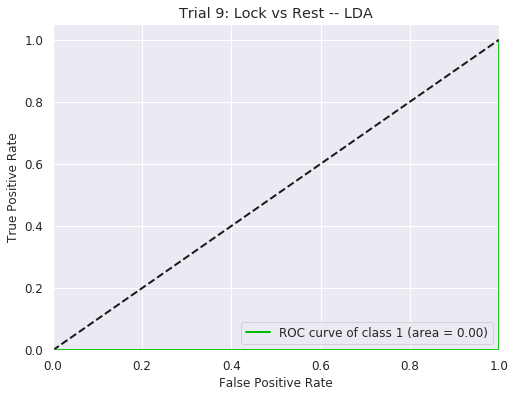

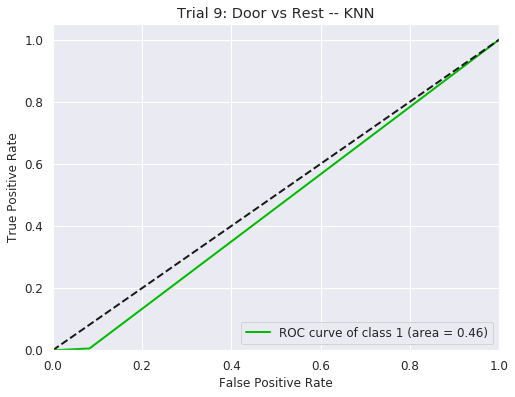

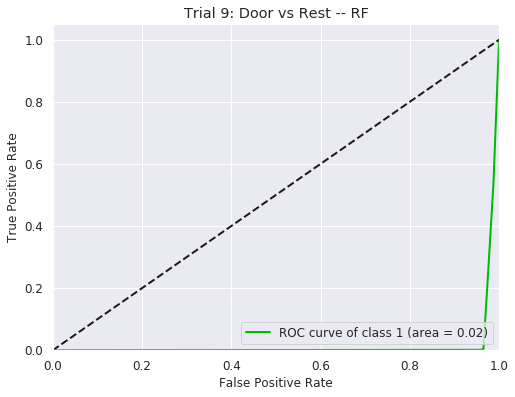

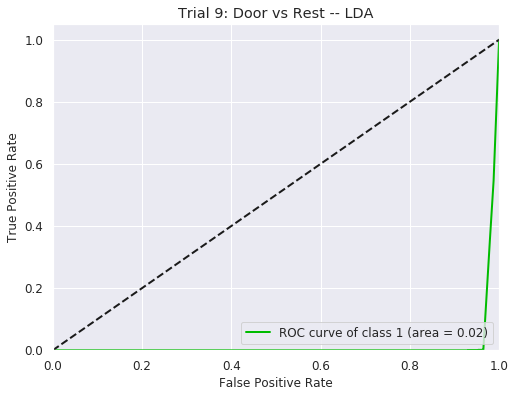

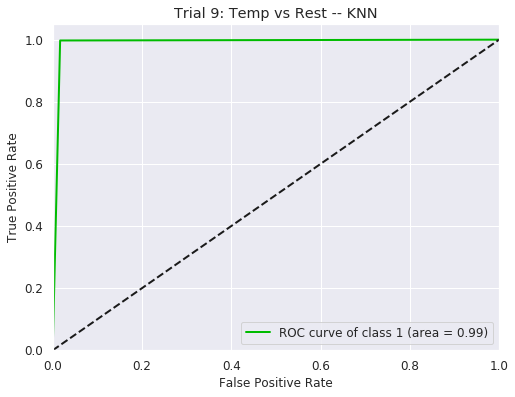

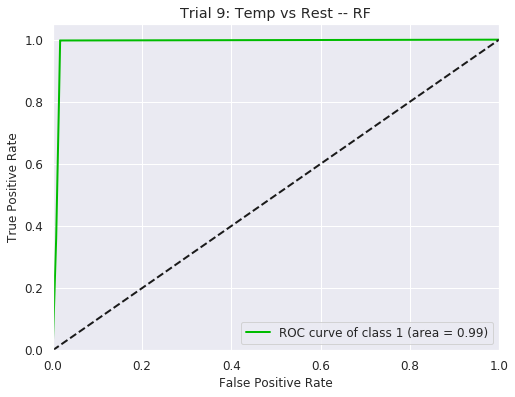

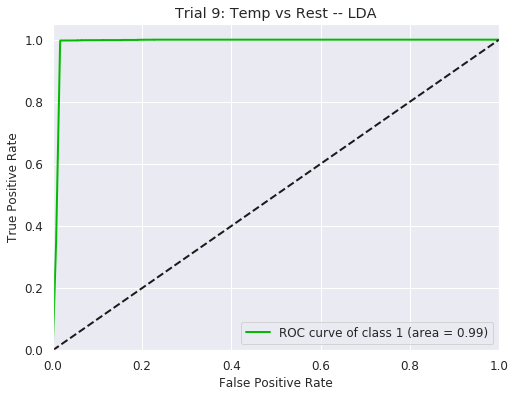

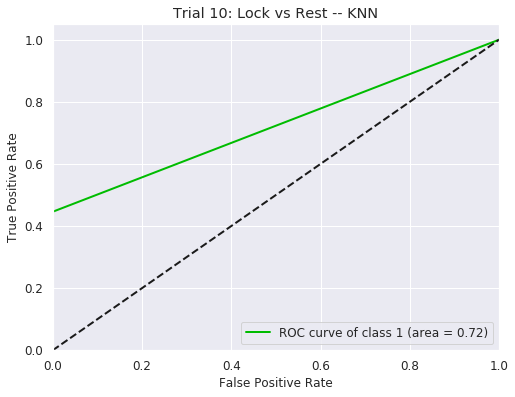

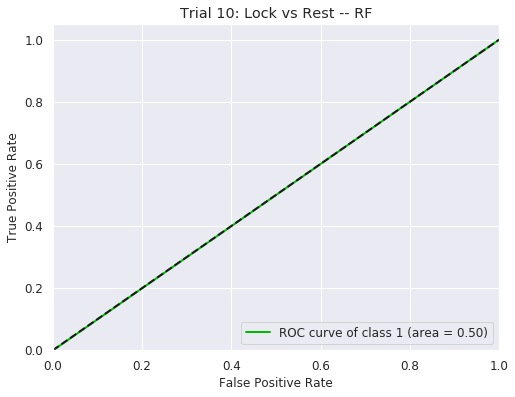

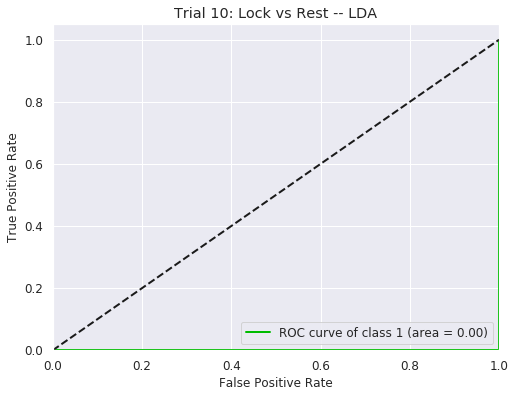

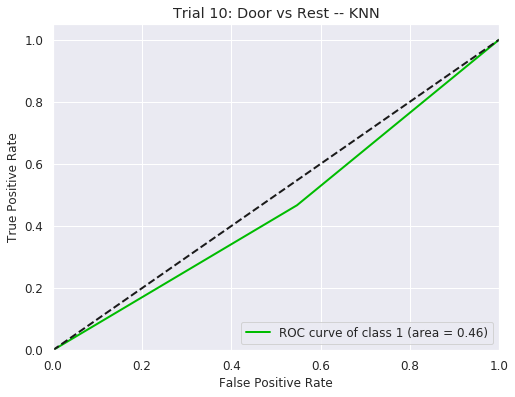

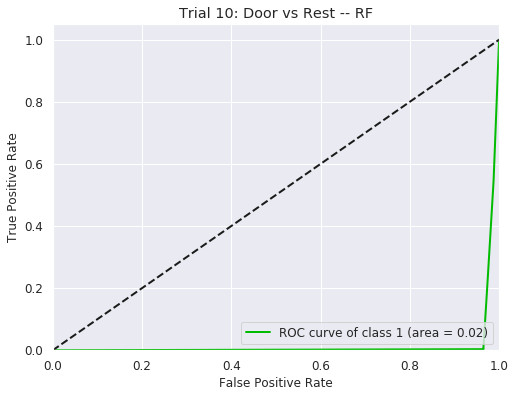

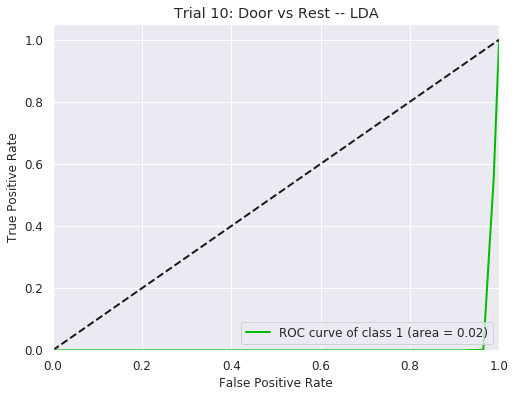

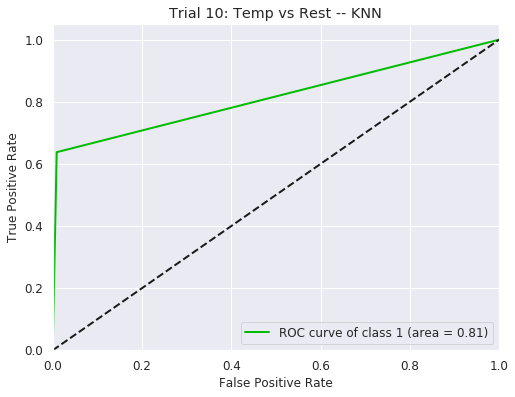

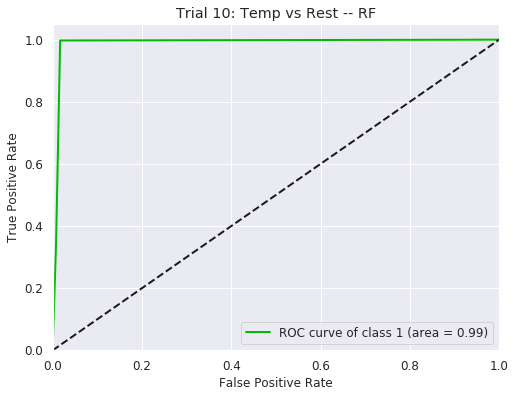

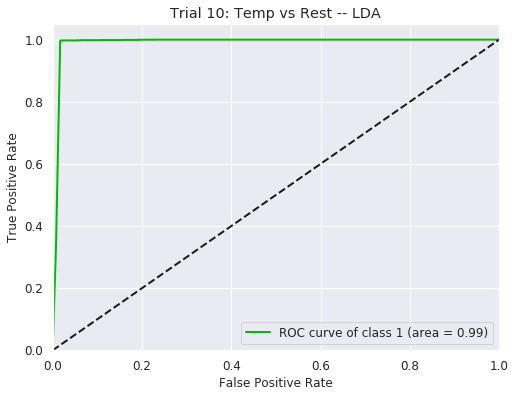

In [15]:
# Plotting ROC curves
sns.set(font_scale=1)
aucs = []
for trial_num, result in enumerate(trial_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()
    
    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']

            # Calculate, store auc
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            aucs.append(auc)
            
            
            # Plot ROC curve
            title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
            skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
                                   classes_to_plot=[1], figsize=(8,6));
            

### Print csv reports

In [16]:
df_alloutput = b.store_trial_results(trial_results)
df_alloutput['AUC'] = aucs
df_alloutput.to_csv('Results/ble-alltrials.csv', mode='w')

In [17]:
cm_metrics = ['TP','FP','FN','TN']
performance_metrics = ['Accuracy', 'Precision','Recall','AUC']

df_meancm = pd.DataFrame(columns=b.get_header(cm_metrics))
df_meanmetrics = pd.DataFrame(columns=b.get_header(performance_metrics))

devalg_combinations = [(x,y) for x in df_alloutput['Device'].unique() for y in df_alloutput['Classifier'].unique()]
for x in devalg_combinations:    
    # Report mean confusion matrix
    cm = df_alloutput.loc[(df_alloutput['Device']==x[0]) & (df_alloutput['Classifier']==x[1]), cm_metrics]
    mean_cm = b.get_mean_metric(cm, cm_metrics)
    mean_cm_series = pd.Series(data=mean_cm, name=str(x), index=df_meancm.columns)
    df_meancm = df_meancm.append(mean_cm_series)
    
    # Report mean performance metrics
    metrics = df_alloutput.loc[(df_alloutput['Device']==x[0]) & (df_alloutput['Classifier']==x[1]), performance_metrics]
    mean_metrics = b.get_mean_metric(metrics, performance_metrics)
    mean_metrics_series = pd.Series(data=mean_metrics, name=str(x), index=df_meanmetrics.columns)
    df_meanmetrics = df_meanmetrics.append(mean_metrics_series)

# Print out to csv    
df_meancm.to_csv('Results/ble-meanCM.csv', mode='w')
df_meanmetrics.to_csv('Results/ble-meanmetrics.csv', mode='w')

In [18]:
df_performance_device = b.report_metrics_across('Device', df_alloutput)
display(df_performance_device)
df_performance_device.to_csv('Results/ble-devtype.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,Recall,SD_Recall,CI_Recall,Precision,SD_Precision,CI_Precision,AUC,SD_AUC,CI_AUC
lock,0.497063,0.311819,0.115807,0.327412,0.334306,0.124158,0.902703,0.128345,0.047666,0.453921,0.362972,0.134805
door,0.168580,0.231865,0.086113,0.071685,0.213618,0.079336,0.003241,0.010161,0.003774,0.167003,0.232915,0.086503
temp,0.793972,0.235476,0.087454,0.990014,0.007974,0.002962,0.986019,0.016616,0.006171,0.957361,0.106427,0.039526


In [19]:
df_performance_classifier = b.report_metrics_across('Classifier', df_alloutput)
display(df_performance_classifier)
df_performance_classifier.to_csv('Results/ble-classifier.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,Recall,SD_Recall,CI_Recall,Precision,SD_Precision,CI_Precision,AUC,SD_AUC,CI_AUC
KNN,0.739746,0.242461,0.090048,0.638697,0.395284,0.146805,0.667468,0.473304,0.175781,0.739746,0.242461,0.090048
RF,0.503519,0.402832,0.149608,0.329540,0.470225,0.174637,0.644442,0.466708,0.173331,0.502689,0.403498,0.149856
LDA,0.216350,0.213803,0.079404,0.420874,0.438916,0.163009,0.580053,0.430342,0.159825,0.335850,0.470834,0.174863


### Time Performance

In [20]:
for trial_num, result in enumerate(trial_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in y_list:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 67.9891731739 seconds
(Door, KNN) : 19.8362720013 seconds
(Door, RF) : 1.08303594589 seconds
(Door, LDA) : 0.590914964676 seconds
(Lock, KNN) : 19.5628378391 seconds
(Lock, RF) : 0.999289035797 seconds
(Lock, LDA) : 0.600116968155 seconds
(Temp, KNN) : 19.9959030151 seconds
(Temp, RF) : 0.955097198486 seconds
(Temp, LDA) : 0.589616060257 seconds

Trial  1
Total time: 77.0404720306 seconds
(Door, KNN) : 23.0945289135 seconds
(Door, RF) : 1.09911608696 seconds
(Door, LDA) : 0.58095908165 seconds
(Lock, KNN) : 22.5544269085 seconds
(Lock, RF) : 1.00135993958 seconds
(Lock, LDA) : 0.586884975433 seconds
(Temp, KNN) : 22.9149491787 seconds
(Temp, RF) : 0.96053314209 seconds
(Temp, LDA) : 0.584814071655 seconds

Trial  2
Total time: 74.2689480782 seconds
(Door, KNN) : 21.9196259975 seconds
(Door, RF) : 1.06016302109 seconds
(Door, LDA) : 0.578398942947 seconds
(Lock, KNN) : 22.0239341259 seconds
(Lock, RF) : 0.989306926727 seconds
(Lock, LDA) : 0.598028182983 seconds
(Te

### Feature Importance

In [21]:
df_featImp = pd.DataFrame()
for i,f in enumerate(b.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [22]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_MOE'] = (2*df_featImp['StdDev']) / np.sqrt(len(df_featImp)-1)

In [23]:
feat_imp = df_featImp[['Mean', 'StdDev', 'CI_MOE']].sort_values('Mean', ascending=False)
display(feat_imp)
feat_imp.to_csv('Results/ble-feature_importance.csv', mode='w')

,Mean,StdDev,CI_MOE
PacketLength,0.320014,0.200135,0.120686
BLE_LL_Length,0.242084,0.111888,0.067471
SCAN_RSP,0.185790,0.142042,0.085655
Assoc_Packets,0.146358,0.098047,0.059125
ADV_IND,0.091602,0.073255,0.044174
SCAN_REQ,0.013595,0.014960,0.009021
Channel_12,0.000301,0.000808,0.000487
Channel_39,0.000139,0.000414,0.000250
ADV_NONCONN_IND,0.000042,0.000041,0.000025
Channel_0,0.000037,0.000022,0.000013


### Plots

lock    245121
door    119701
temp     53699
Name: DeviceType, dtype: int64


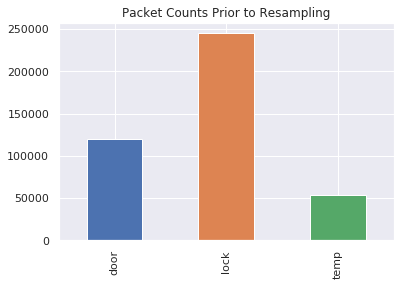

In [24]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#
devtype_df = df["DeviceType"].value_counts().sort_index()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");
print df["DeviceType"].value_counts()

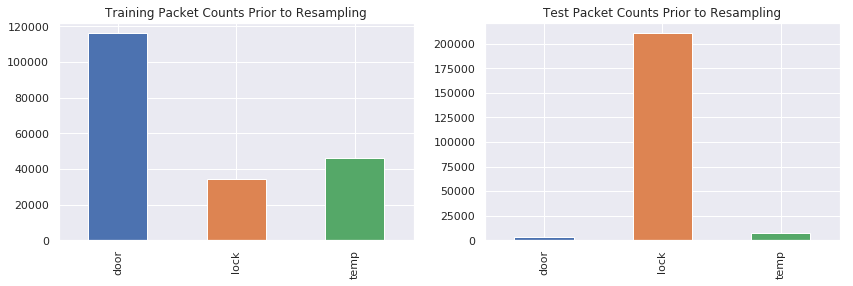

In [25]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling");


/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


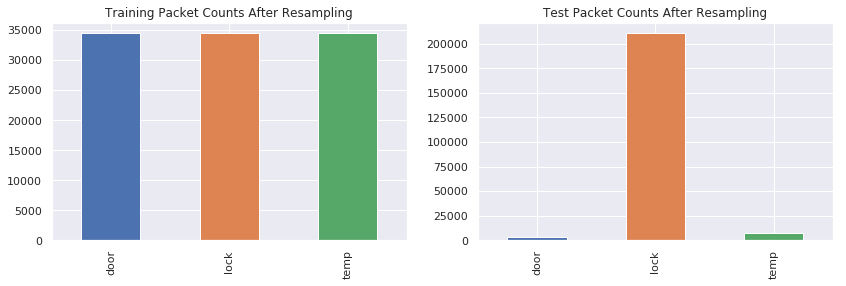

In [26]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[ble_devicetypes].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
